In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 선형회귀

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

그림 저장: generated_data_lot


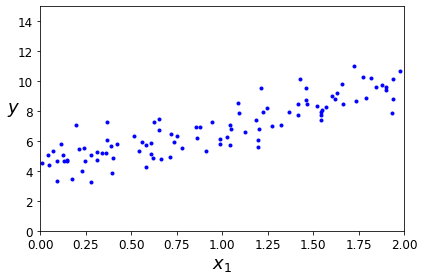

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
save_fig("generated_data_lot")
plt.show()

In [4]:
X_b = np.c_[np.ones((100,1)), X] # 모든 샘플에 X0 =1 을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

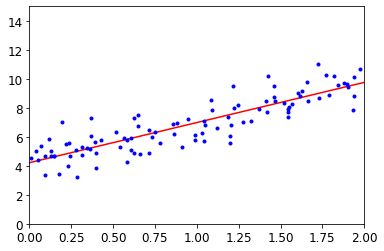

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
# 선형회귀
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# 경사하강법

In [11]:
# 중요한 파라미터는 스탭의 크기, 학습률이 너무 크면 반대로넘어가서 발산할수 있음
# 경사하강법을 사용할때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 합니다. Scaler

eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) -y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [14]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


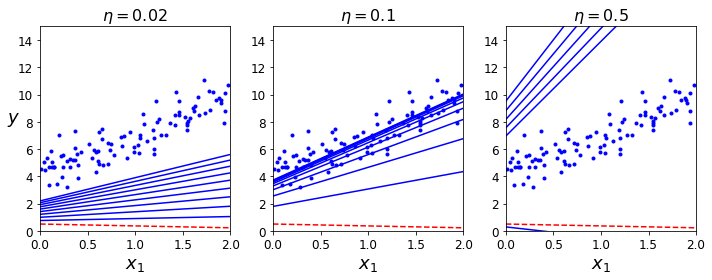

In [15]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# 확률적 경사 하강법

그림 저장: sgd_plot


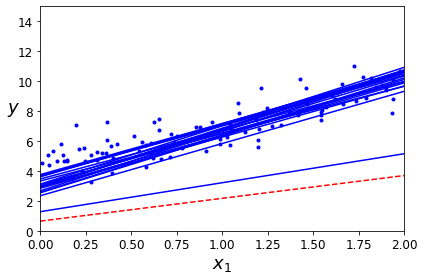

In [16]:
# 매 스텝 마다 한개의 샘플을 무작위로 선택하고 그 샘플에 대한 그레이디언트를 계산함
# 속도는 빠를수 있으나 배치 경사 하강법보다 불안정하고 요동치며 시간이 지나면 좋은 파라미터가 구해지겠지만 최적치는 아님
# 딜레마를 해결하는 한 가지 방법은 학습률 을 점진적으로 감소히키는 것임

n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # 무작위 초기화

theta_path_sgd = []

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # 책에는 없음
            y_predict = X_new_b.dot(theta)           # 책에는 없음
            style = "b-" if i > 0 else "r--"         # 책에는 없음
            plt.plot(X_new, y_predict, style)        # 책에는 없음
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index: random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  
    
    
plt.plot(X, y, "b.")                                 # 책에는 없음
plt.xlabel("$x_1$", fontsize=18)                     # 책에는 없음
plt.ylabel("$y$", rotation=0, fontsize=18)           # 책에는 없음
plt.axis([0, 2, 0, 15])                              # 책에는 없음
save_fig("sgd_plot")                                 # 책에는 없음
plt.show()                                           # 책에는 없음

In [17]:
theta

array([[4.20742938],
       [2.74264448]])

In [18]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21077682]), array([2.76927873]))